<a href="https://colab.research.google.com/github/jiiiisoo/machinelearning/blob/main/supervised%20learning_regression_choosing%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **모델의 선택**
모델 간 비교에도 선형 기저 함수 모델의 M을 결정할 때와 같이 미지의 데이터에 대한 예측 정확도로 평가한다. 즉, holdout 검증과 k-fold 교차검증을 통해 모델의 좋고 나쁨을 평가할 수 있다.

모델 A에 LOOCV를 사용하여 앞서 구했던 선형 기저 함수 모델의 LOOCV 결과와 비교하면

In [ ]:
##데이터
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 나이에 따른 키의 인공 데이터 생성
np.random.seed(seed=1)
X_min=4 #X의 하한
X_max=30 #X의 상한
X_n=16 #데이터 개수
X=5+25*np.random.rand(X_n) #16명 나이 설정
Prm_c=[170, 108, 0.2] #생성 매개 변수
T=Prm_c[0]-Prm_c[1]*np.exp(-Prm_c[2]*X)+4*np.random.randn(X_n) #T:출력값
np.savez('ch5_data.npz', X=X, X_min=X_min, X_max=X_max, X_n=X_n, T=T)

##모델A
def model_A(x,w):
  y=w[0]-w[1]*np.exp(-w[2]*x)
  return y

def show_model_A(w):
  xb=np.linspace(X_min,X_max,100)
  y=model_A(xb,w)
  plt.plot(xb,y,c=[.5,.5,.5], lw=4)

def mse_model_A(w,x,t):
  y=model_A(x,w)
  mse=np.mean((y-t)**2)
  return mse

##최적화
from scipy.optimize import minimize
def fit_model_A(w_init,x,t):
  res1=minimize(mse_model_A,w_init, args=(x,t), method='powell') #첫번째 인수: 최소화할 목표 함수, 두번째: w 초기값, 세번째: 함수 최적화하는 매개 변수 w 이외의 변수, 네번째: 사용할 알고리즘
                                                                 # powell 알고리즘: 최소화 함수 사용할 때 늦게 수렴되거나 수렴이 보장되지 않는 경우 실험적으로 사용하는 알고리즘
  return res1.x #??

In [ ]:
##model A와 비교 위한 선형 기저 함수 모델의 필요한 함수들 가져옴

#가우스 함수
def gauss(x,mu,s):
  return np.exp(-(x-mu)**2/(2*s**2))

##선형 기저 함수 모델
def gauss_func(w,x):
  m=len(w)-1 # w의 개수는 가우스함수 개수보다 하나 많기 때문
  mu=np.linspace(5,30,m)
  s=mu[1]-mu[0]
  y=np.zeros_like(x) #x와 같은 크기로 요소가 0의 행렬 y를 작성
  for j in range(m):
    y=y+w[j]*gauss(x,mu[j],s)
  y=y+w[m]
  return y

##선형 기저 함수 모델의 mse (평균 제곱 오차)
#피팅의 수준 산출
def mse_gauss_func(x,t,w):
  y=gauss_func(w,x)
  mse=np.mean((y-t)**2)
  return mse

##선형 기저 함수 모델의 해석해 (정확한 값)
def fit_gauss_func(x,t,m):
  mu=np.linspace(5,30,m)
  s=mu[1]-mu[0]
  n=x.shape[0]
  psi=np.ones((n,m+1)) #항상 1 출력하는 더미함수 (psi_(m+1)=1 만들기 위함)
  for j in range (m):
    psi[:,j]=gauss(x,mu[j],s)
  psi_T=np.transpose(psi)
  
  a=np.linalg.inv(psi_T.dot(psi))
  b=a.dot(psi_T)
  w=b.dot(t)
  return w

##K-fold-cross-validation

def Kfold_mse_gauss(x,t,m,k):
  n=x.shape[0] #n: x의 데이터 개수
  mse_train=np.zeros(k)
  mse_test=np.zeros(k)
  for i in range(0,k):
    x_train=x[np.fmod(range(n),k)!=i] #np.fmod(n,k): n을 k로 나눈 나머지 출력 / n을 range(n)으로 하면 0~n-1까지 각 수를 k로 나눈 나머지 출력됨
    t_train=t[np.fmod(range(n),k)!=i]
    x_test=x[np.fmod(range(n),k)==i]
    t_test=t[np.fmod(range(n),k)==i]
    wm=fit_gauss_func(x_train,t_train,m)
    mse_train[i]=mse_gauss_func(x_train,t_train,wm)
    mse_test[i]=mse_gauss_func(x_test,t_test,wm)
  return mse_train,mse_test

##main
M=range(2,8)
K=16 #K의 최대 (K=N이 최대이므로)
Cv_Gauss_train=np.zeros((K,len(M)))
Cv_Gauss_test=np.zeros((K,len(M)))
for i in range (0,len(M)):
  Cv_Gauss_train[:,i],Cv_Gauss_test[:,i]=Kfold_mse_gauss(X,T,M[i],K)
mean_Gauss_train=np.sqrt(np.mean(Cv_Gauss_train,axis=0)) #axis=0 무슨 의미??
mean_Gauss_test=np.sqrt(np.mean(Cv_Gauss_test,axis=0))

Gauss (M=3) SD=6.51 cm
Model A SD=4.72 cm


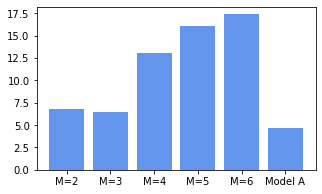

In [ ]:
## kfold_modelA
def Kfold_model_A(x,t,k):
  n=len(x)
  mse_train=np.zeros(k)
  mse_test=np.zeros(k)
  for i in range (0,k):
    x_train=x[np.fmod(range(n),k)!=i]
    t_train=t[np.fmod(range(n),k)!=i]
    x_test=x[np.fmod(range(n),k)==i]
    t_test=t[np.fmod(range(n),k)==i]
    wm=fit_model_A(np.array([169,113,0.2]),x_train,t_train) #w_init은 사용자 지정
    mse_train[i]=mse_model_A(wm,x_train,t_train)
    mse_test[i]=mse_model_A(wm,x_test,t_test)
  return mse_train, mse_test

##main
K=16
Cv_A_train,Cv_A_test=Kfold_model_A(X,T,K)
mean_A_test=np.sqrt(np.mean(Cv_A_test))
print('Gauss (M=3) SD={:.2f} cm'.format(mean_Gauss_test[1]))
print('Model A SD={:.2f} cm'.format(mean_A_test))
SD=np.append(mean_Gauss_test[0:5],mean_A_test)
M=range(6)
label=['M=2','M=3','M=4','M=5','M=6','Model A']
plt.figure(figsize=(5,3))
plt.bar(M,SD,tick_label=label, align='center',facecolor='cornflowerblue')
plt.show()



LOOCV로 선형 기저 함수에서 M:2~6일 경우와 model A의 오차 SD를 비교해보면 model A가 M=3일 때보다 작은 것으로 보아 model A가 데이터에 더 적합함을 볼 수 있다.

# **정리**

어느 데이터든 알맞은 함수와 모델을 찾으려면

1. 입력 변수와 목표 변수의 데이터를 둔다.

2. 무엇을 가지고 예측의 정확도를 높일지 목적 함수를 결정한다. (지금까지는 평균 제곱 오차로 결정했음)

3. 모델의 후보를 결정한다. (선형 회귀 모델, 곡선 모델, 데이터의 특성 반영한 모델 등등)

4. 검증을 통해 최적의 매개 변수를 결정한다. (holdout 검증을 이용한다면 test data, training data를 나누어 training data로 목적 함수가 최대 또는 최소가 되도록 변수(w)를 결정한다.)

5. test data의 입력변수 를 각 모델에 대입하여 test data를 예측하여 오차가 적은 모델을 선택한다.

6. 모델이 결정되면 보유한 데이터를 모두 사용하여 최적의 모델의 매개 변수를 최적화한다.


출처: 파이썬으로 배우는 머신러닝의 교과서-이시카와아키히코